# Libraries

In [1]:
!pip install pandas_ta numpy==1.23.5 hyperliquid-python-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.0/587.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.0 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=7e826adad3f6ed9fc552fbb9e88107ece01ec5bf9a16a5d99dc685bb045bafa8
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d9

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime, timedelta

import plotly.graph_objects as go
import plotly.exceptions as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

import hyperliquid
from hyperliquid.info import Info
from hyperliquid.utils.constants import MAINNET_API_URL, TESTNET_API_URL

import requests
import threading
import time
import json

# 1. Market Data

In [ ]:
info = Info(TESTNET_API_URL)

CURRENCY = 'ETH'

In [ ]:
def fetch_candles_df(token: str, interval: str = '1h', info: Info = Info(TESTNET_API_URL)) -> pd.DataFrame:
    """
    Fetch candle data for a given token and construct a DataFrame.

    Args:
        token (str): Token symbol (e.g. 'BTC', 'ETH')
        interval (str): Candle interval ('5m','15m','1h','4h','1d')
        info (Info): Hyperliquid Info instance for API access

    Returns:
        pd.DataFrame: DataFrame with columns:
            - timestamp (datetime): Start time of the candle
            - end (datetime): End time of the candle
            - open (float): Opening price
            - close (float): Closing price
            - high (float): Highest price
            - low (float): Lowest price
            - volume (float): Trading volume
    """
    start_time = int(datetime.now().timestamp()*1000) - int(timedelta(days=5000).total_seconds()*1000)
    end_time = int(datetime.now().timestamp()*1000)

    candles = info.candles_snapshot(token, interval, start_time, end_time)

    df = pd.DataFrame(candles)

    df['t'] = pd.to_datetime(df['t'], unit='ms')
    df['T'] = pd.to_datetime(df['T'], unit='ms')

    for col in ['o', 'c', 'h', 'l', 'v']:
        df[col] = df[col].astype(float)

    df = df.sort_values('t')
    df.rename(columns={
        'T': 'end',
        'o': 'open',
        'c': 'close',
        'h': 'high',
        'l': 'low',
        'v': 'volume',
        't': 'timestamp',
    }, inplace=True)
    return df

In [ ]:
df_1m = fetch_candles_df(CURRENCY, interval='1m')
df_5m = fetch_candles_df(CURRENCY, interval='5m')
df_1h = fetch_candles_df(CURRENCY, interval='1h')
df_1d = fetch_candles_df(CURRENCY, interval='1d')

In [ ]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add various technical indicators to the price DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with OHLCV data

    Returns:
        pd.DataFrame: Original DataFrame with additional columns:
            - returns (float): Percentage price changes
            - log_returns (float): Natural logarithm of returns
            - SMA_20 (float): 20-period Simple Moving Average
            - SMA_50 (float): 50-period Simple Moving Average
            - EMA_20 (float): 20-period Exponential Moving Average
            - RSI (float): Relative Strength Index
            - MACD (float): Moving Average Convergence Divergence
            - MACD_signal (float): MACD signal line
    """
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close']).diff()

    df['SMA_20'] = df.ta.sma(length=20)
    df['SMA_50'] = df.ta.sma(length=50)
    df['EMA_20'] = df.ta.ema(length=20)
    df['RSI'] = df.ta.rsi()
    df['MACD'] = df.ta.macd()['MACD_12_26_9']
    df['MACD_signal'] = df.ta.macd()['MACDs_12_26_9']
    # df['BB_upper'], df['BB_middle'], df['BB_lower'] = df.ta.bbands(length=20)

    return df

In [ ]:
df_1m = add_technical_indicators(df_1m)
df_5m = add_technical_indicators(df_5m)
df_1h = add_technical_indicators(df_1h)
df_1d = add_technical_indicators(df_1d)

In [ ]:
def plot_price_volume(df: pd.DataFrame, title: str) -> None:
    """
    Create an interactive plot with price candlesticks and volume.

    Args:
        df (pd.DataFrame): DataFrame with OHLCV and technical indicators
        title (str): Title for the plot

    Returns:
        None: Displays an interactive Plotly figure
    """
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                       vertical_spacing=0.03,
                       row_heights=[0.7, 0.3])

    fig.add_trace(go.Candlestick(x=df['timestamp'],
                                open=df['open'],
                                high=df['high'],
                                low=df['low'],
                                close=df['close'],
                                name='OHLC'),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['SMA_20'],
                            name='SMA 20', line=dict(color='blue')),
                 row=1, col=1)
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['SMA_50'],
                            name='SMA 50', line=dict(color='red')),
                 row=1, col=1)

    fig.add_trace(go.Bar(x=df['timestamp'], y=df['volume'],
                        name='Volume'),
                 row=2, col=1)

    fig.update_layout(title=title, height=800)
    fig.show()

In [ ]:
plot_price_volume(df_1m, f'{CURRENCY} Price and Volume Analysis (1m)')
plot_price_volume(df_5m, f'{CURRENCY} Price and Volume Analysis (5m)')
plot_price_volume(df_1h, f'{CURRENCY} Price and Volume Analysis (1h)')
plot_price_volume(df_1d, f'{CURRENCY} Price and Volume Analysis (1d)')

In [ ]:
def plot_returns_analysis(df: pd.DataFrame, title: str) -> None:
    """
    Create an interactive plot showing returns and RSI analysis.

    Args:
        df (pd.DataFrame): DataFrame with returns and RSI data
        title (str): Title for the plot

    Returns:
        None: Displays an interactive Plotly figure
    """
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                       vertical_spacing=0.03)

    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['returns'],
                            name='Returns', line=dict(color='blue')),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['RSI'],
                            name='RSI', line=dict(color='purple')),
                 row=2, col=1)

    fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

    fig.update_layout(title=title, height=800)
    fig.show()

In [ ]:
plot_returns_analysis(df_1m, f'{CURRENCY} Returns and RSI Analysis (1m)')
plot_returns_analysis(df_5m, f'{CURRENCY} Returns and RSI Analysis (5m)')
plot_returns_analysis(df_1h, f'{CURRENCY} Returns and RSI Analysis (1h)')
plot_returns_analysis(df_1d, f'{CURRENCY} Returns and RSI Analysis (1d)')

In [ ]:
def print_statistical_analysis(df: pd.DataFrame, title: str) -> None:
    """
    Print key statistical metrics for the price data.

    Args:
        df (pd.DataFrame): DataFrame with price and returns data
        title (str): Title for the analysis output

    Returns:
        None: Prints statistical analysis to console including:
            - Mean return
            - Standard deviation
            - Skewness
            - Kurtosis
            - Augmented Dickey-Fuller test results
    """
    print(f"\n{title} Statistical Analysis:")
    print("="*50)
    print(f"Mean Return: {df['returns'].mean():.4f}")
    print(f"Standard Deviation: {df['returns'].std():.4f}")
    print(f"Skewness: {df['returns'].skew():.4f}")
    print(f"Kurtosis: {df['returns'].kurtosis():.4f}")

    adf_result = adfuller(df['close'].dropna())
    print(f"\nADF Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Critical Values: {adf_result[4]}")

In [ ]:
print_statistical_analysis(df_1m, f'{CURRENCY} Statistical Analysis (1m)')
print_statistical_analysis(df_5m, f'{CURRENCY} Statistical Analysis (5m)')
print_statistical_analysis(df_1h, f'{CURRENCY} Statistical Analysis (1h)')
print_statistical_analysis(df_1d, f'{CURRENCY} Statistical Analysis (1d)')


ETH Statistical Analysis (1m) Statistical Analysis:
Mean Return: 0.0000
Standard Deviation: 0.0012
Skewness: -1.5877
Kurtosis: 65.7707

ADF Test Results:
ADF Statistic: -2.2091
p-value: 0.2029
Critical Values: {'1%': -3.431549556364406, '5%': -2.8620700839121787, '10%': -2.5670521626393175}

ETH Statistical Analysis (5m) Statistical Analysis:
Mean Return: -0.0000
Standard Deviation: 0.0031
Skewness: 1.0547
Kurtosis: 30.6083

ADF Test Results:
ADF Statistic: -2.0685
p-value: 0.2574
Critical Values: {'1%': -3.4320308674757216, '5%': -2.862282715190103, '10%': -2.5671653561652974}

ETH Statistical Analysis (1h) Statistical Analysis:
Mean Return: -0.0004
Standard Deviation: 0.0099
Skewness: 0.1477
Kurtosis: 16.2760

ADF Test Results:
ADF Statistic: -1.7641
p-value: 0.3984
Critical Values: {'1%': -3.435730242325657, '5%': -2.863915864680021, '10%': -2.5680349476516726}

ETH Statistical Analysis (1d) Statistical Analysis:
Mean Return: 0.0009
Standard Deviation: 0.0344
Skewness: 0.3068
Kurto

In [ ]:
def plot_correlation_heatmap(df: pd.DataFrame, title: str) -> None:
    """
    Create a correlation heatmap for key market variables.

    Args:
        df (pd.DataFrame): DataFrame with market data
        title (str): Title for the plot

    Returns:
        None: Displays a matplotlib/seaborn heatmap
    """
    corr_cols = ['open', 'high', 'low', 'close', 'volume', 'returns', 'RSI']
    corr_matrix = df[corr_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'{title} Correlation Heatmap')
    plt.show()

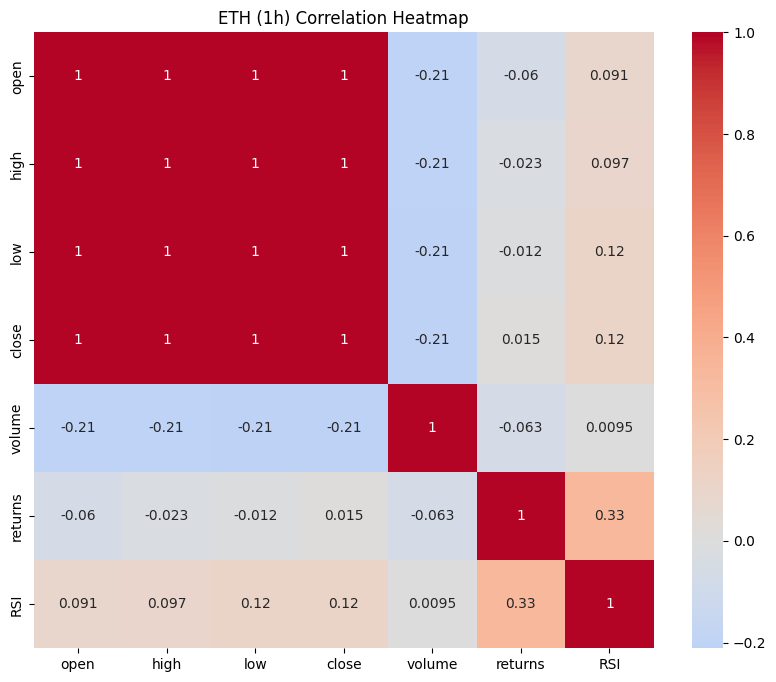

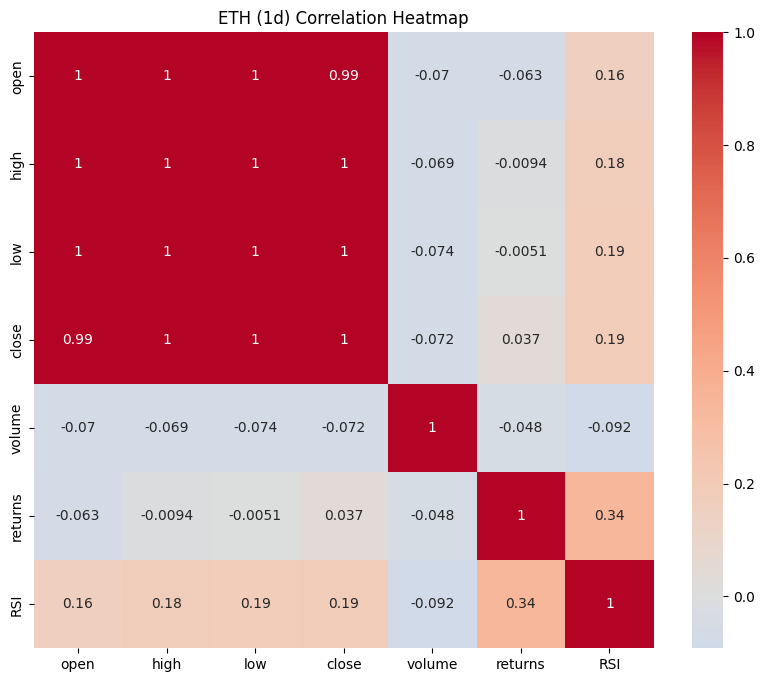

In [ ]:
plot_correlation_heatmap(df_1h, f'{CURRENCY} (1h)')
plot_correlation_heatmap(df_1d, f'{CURRENCY} (1d)')

In [ ]:
def plot_volatility(df: pd.DataFrame, title: str) -> None:
    """
    Create a plot showing rolling volatility over time.

    Args:
        df (pd.DataFrame): DataFrame with returns data
        title (str): Title for the plot

    Returns:
        None: Displays an interactive Plotly figure showing annualized volatility
    """
    df['volatility'] = df['returns'].rolling(window=20).std() * np.sqrt(252)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['volatility'],
                            name='Volatility', line=dict(color='red')))

    fig.update_layout(title=f'{title} Volatility Analysis',
                     xaxis_title='Date',
                     yaxis_title='Annualized Volatility')
    fig.show()

In [ ]:
plot_volatility(df_1m, f'{CURRENCY} (1m)')
plot_volatility(df_5m, f'{CURRENCY} (5m)')
plot_volatility(df_1h, f'{CURRENCY} (1h)')
plot_volatility(df_1d, f'{CURRENCY} (1d)')

In [ ]:
def plot_distribution(df: pd.DataFrame, title: str) -> None:
    """
    Create plots showing the distribution of returns.

    Args:
        df (pd.DataFrame): DataFrame with returns data
        title (str): Title for the plots

    Returns:
        None: Displays interactive Plotly figures showing:
            - Returns distribution histogram
            - QQ plot comparing returns to normal distribution
    """
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Histogram(x=df['returns'], name='Returns Distribution',
                              nbinsx=50), row=1, col=1)

    fig.add_trace(go.Scatter(x=np.sort(df['returns']),
                            y=np.sort(np.random.normal(0, 1, len(df))),
                            mode='markers', name='QQ Plot'), row=1, col=2)

    fig.update_layout(title=f'{title} Distribution Analysis', height=400)
    fig.show()

In [ ]:
plot_distribution(df_1m, f'{CURRENCY} (1m)')
plot_distribution(df_5m, f'{CURRENCY} (5m)')
plot_distribution(df_1h, f'{CURRENCY} (1h)')
plot_distribution(df_1d, f'{CURRENCY} (1d)')

# 2. On-chain Data

## DeFi TVL (in ETH)

In [19]:
class DefiDataCollector:
    def __init__(self):
        self.historical_url = "https://api.llama.fi/v2/historicalChainTvl/Ethereum"
        self.realtime_url = "https://api.llama.fi/v2/chains"
        self.is_collecting = False
        self.thread = None

    def _get_eth_tvl(self):
        """Получает только ETH TVL из API"""
        try:
            response = requests.get(self.realtime_url, timeout=10)
            if response.status_code != 200:
                print(f"HTTP Error: {response.status_code}")
                return None

            chains_data = response.json()
            for chain in chains_data:
                if chain.get('name') == 'Ethereum':
                    return chain.get('tvl')

            print("Ethereum data not found in API response")
            return None

        except Exception as e:
            print(f"Request failed: {str(e)}")
            return None

    def get_historical_tvl(self, start_date: str, end_date: str, filename: str) -> pd.DataFrame:
        """Получение исторических данных TVL Ethereum"""
        try:
            response = requests.get(self.historical_url)
            data = response.json()

            df = pd.DataFrame(data)
            df['date'] = pd.to_datetime(df['date'], unit='s').dt.date

            mask = (df['date'] >= pd.to_datetime(start_date).date()) & \
                   (df['date'] <= pd.to_datetime(end_date).date())
            filtered_df = df.loc[mask]

            if not filtered_df.empty:
                filtered_df.to_csv(filename, index=False)
                print(f"Исторические данные сохранены в {filename}")
            else:
                print("Нет данных за указанный период")

            return filtered_df

        except Exception as e:
            print(f"Error: {e}")
            return pd.DataFrame()

    def _realtime_worker(self, duration: int, interval: int, filename: str):
        """Поток для сбора данных в реальном времени"""
        start_time = datetime.now()
        end_time = start_time + timedelta(seconds=duration)

        while datetime.now() < end_time and self.is_collecting:
            eth_tvl = self._get_eth_tvl()

            if eth_tvl is not None:
                try:
                    with open(filename, 'a') as f:
                        f.write(f"{datetime.now().isoformat()},{eth_tvl}\n")
                    print(f"Собраны данные: {datetime.now()} - ETH TVL: {eth_tvl}")
                except Exception as e:
                    print(f"Ошибка записи в файл: {str(e)}")

            time.sleep(interval)

    def start_realtime_collection(self, duration: int, interval: int, filename: str):
        """Запуск сбора данных"""
        if self.is_collecting:
            print("Сбор уже запущен")
            return

        with open(filename, 'w') as f:
            f.write("timestamp,eth_tvl\n")

        self.is_collecting = True
        self.thread = threading.Thread(
            target=self._realtime_worker,
            args=(duration, interval, filename)
        )
        self.thread.start()

        print(f"Сбор данных начат. Длительность: {duration} сек, интервал: {interval} сек")

    def wait_until_done(self):
        """Ожидание завершения потока"""
        if self.thread is not None:
            self.thread.join()

    def stop_collection(self):
        """Остановка сбора данных"""
        self.is_collecting = False
        print("Сбор данных остановлен")

In [20]:
collector = DefiDataCollector()

In [21]:
collector.get_historical_tvl(
    start_date="2024-01-01",
    end_date="2024-01-07",
    filename="historical_tvl.csv"
)

Исторические данные сохранены в historical_tvl.csv


,date,tvl
2075,2024-01-01,29628966870
2076,2024-01-02,30792906670
2077,2024-01-03,30919781303
2078,2024-01-04,29235164221
2079,2024-01-05,30354009956
2080,2024-01-06,30362276216
2081,2024-01-07,30145125818


In [22]:
collector.start_realtime_collection(
    duration=10,
    interval=2,
    filename="realtime_tvl.csv"
)
collector.wait_until_done()

eth_tvl_realtime = pd.read_csv('realtime_tvl.csv')
eth_tvl_realtime

Сбор данных начат. Длительность: 10 сек, интервал: 2 сек
Собраны данные: 2025-04-17 20:52:27.032651 - ETH TVL: 46830579763.79546
Собраны данные: 2025-04-17 20:52:29.116282 - ETH TVL: 46830579763.79546
Собраны данные: 2025-04-17 20:52:31.204566 - ETH TVL: 46830579763.79546
Собраны данные: 2025-04-17 20:52:33.294618 - ETH TVL: 46830579763.79546
Собраны данные: 2025-04-17 20:52:35.386204 - ETH TVL: 46830579763.79546


,timestamp,eth_tvl
0,2025-04-17T20:52:27.032578,4.683058e+10
1,2025-04-17T20:52:29.116225,4.683058e+10
2,2025-04-17T20:52:31.204503,4.683058e+10
3,2025-04-17T20:52:33.294559,4.683058e+10
4,2025-04-17T20:52:35.386133,4.683058e+10
